In [171]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import *
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score

In [172]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
# Set up paths
script_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
tableu_dir = os.path.join(root_dir, 'tableau')
porcessed_data_dir = os.path.join(script_dir, 'processed_data')

In [174]:
output_df = pd.read_csv(os.path.join(tableu_dir, 'bardis_ensemble_python_ver_5000.csv'))
output_df

,Resources,Economy,Bureaucracy,Pollution,time,run_id
0,1.000000,1.000000,1.000000,1.000000,0.0,1.0
1,0.968867,1.015463,1.002266,0.989368,0.2,1.0
2,0.937852,1.030392,1.004657,0.978862,0.4,1.0
3,0.907016,1.044750,1.007171,0.968459,0.6,1.0
4,0.876418,1.058504,1.009802,0.958140,0.8,1.0
...,...,...,...,...,...,...
5004995,-0.000017,-0.000201,0.043258,0.045221,199.2,5000.0
5004996,-0.000017,-0.000201,0.043100,0.045058,199.4,5000.0
5004997,-0.000017,-0.000201,0.042942,0.044895,199.6,5000.0
5004998,-0.000017,-0.000201,0.042785,0.044733,199.8,5000.0


In [175]:
output_df.min()

Resources     -0.000582
Economy       -0.001136
Bureaucracy   -0.000666
Pollution     -0.024338
time           0.000000
run_id         1.000000
dtype: float64

In [176]:
fe = FeatureExtractor()
edau = EDAUtils()

# Time Series Clustering (Simple Approach)

## Create freatures df

In [177]:
transformed_output_df = output_df.groupby("run_id").apply(fe.extract_ts_features).reset_index()
transformed_output_df.head() 

/tmp/ipykernel_5993/2261743549.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transformed_output_df = output_df.groupby("run_id").apply(fe.extract_ts_features).reset_index()


,run_id,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,...,Pollution_max_200,Pollution_min_0,Pollution_min_25,Pollution_min_50,Pollution_min_75,Pollution_min_100,Pollution_min_125,Pollution_min_150,Pollution_min_175,Pollution_min_200
0,1.0,-0.000333,1.0,-0.000333,4.078005,1.000333,0.0,-1.000333,-0.099798,-0.044131,...,0.187204,0.233048,0.198781,0.196383,0.194562,0.192709,0.190859,0.189023,0.187204,0.187204
1,2.0,-0.000057,1.0,-0.000057,3.254820,1.000057,0.0,-1.000057,-0.111005,0.000000,...,0.257656,0.344335,0.308847,0.301477,0.292699,0.283613,0.274698,0.266042,0.257656,0.257656
2,3.0,-0.000046,1.0,-0.000046,4.719179,1.000046,0.0,-1.000046,-0.093226,-0.047939,...,0.762727,1.000000,1.487401,1.330770,1.190615,1.065205,0.952988,0.852576,0.762727,0.762727
3,4.0,-0.000146,1.0,-0.000146,5.885257,1.000146,0.0,-1.000146,-0.084761,-0.040375,...,0.014237,1.000000,0.613701,0.328344,0.175632,0.093906,0.050169,0.026763,0.014237,0.014237
4,5.0,-0.000198,1.0,-0.000198,4.738348,1.000198,0.0,-1.000198,-0.096086,-0.055946,...,0.321291,0.313347,0.282972,0.283623,0.290321,0.296705,0.302771,0.308842,0.315008,0.321291


In [191]:
transformed_output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 193 entries, run_id to Pollution_min_200
dtypes: float64(193)
memory usage: 7.4 MB


## Data Cleaning

- Drop duplicates?

In [192]:
transformed_output_df.isnull().sum().sort_values(ascending=False).head()


run_id             0
Resources_final    0
Resources_max      0
Resources_min      0
Resources_auc      0
dtype: int64

In [193]:
# Check for duplicates
transformed_output_df.duplicated().sum()

np.int64(0)

In [194]:
# Drop run_id to create features dataframe
features_df = transformed_output_df.drop(columns=["run_id"])
features_df.head()

,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,Resources_delta_15,...,Pollution_max_200,Pollution_min_0,Pollution_min_25,Pollution_min_50,Pollution_min_75,Pollution_min_100,Pollution_min_125,Pollution_min_150,Pollution_min_175,Pollution_min_200
0,-0.000333,1.0,-0.000333,4.078005,1.000333,0.0,-1.000333,-0.099798,-0.044131,0.000000,...,0.187204,0.233048,0.198781,0.196383,0.194562,0.192709,0.190859,0.189023,0.187204,0.187204
1,-0.000057,1.0,-0.000057,3.254820,1.000057,0.0,-1.000057,-0.111005,0.000000,0.000000,...,0.257656,0.344335,0.308847,0.301477,0.292699,0.283613,0.274698,0.266042,0.257656,0.257656
2,-0.000046,1.0,-0.000046,4.719179,1.000046,0.0,-1.000046,-0.093226,-0.047939,0.000000,...,0.762727,1.000000,1.487401,1.330770,1.190615,1.065205,0.952988,0.852576,0.762727,0.762727
3,-0.000146,1.0,-0.000146,5.885257,1.000146,0.0,-1.000146,-0.084761,-0.040375,-0.020696,...,0.014237,1.000000,0.613701,0.328344,0.175632,0.093906,0.050169,0.026763,0.014237,0.014237
4,-0.000198,1.0,-0.000198,4.738348,1.000198,0.0,-1.000198,-0.096086,-0.055946,0.000000,...,0.321291,0.313347,0.282972,0.283623,0.290321,0.296705,0.302771,0.308842,0.315008,0.321291


## EDA

In [195]:
features_df.describe()

,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,Resources_delta_15,...,Pollution_max_200,Pollution_min_0,Pollution_min_25,Pollution_min_50,Pollution_min_75,Pollution_min_100,Pollution_min_125,Pollution_min_150,Pollution_min_175,Pollution_min_200
count,5.000000e+03,5.000000e+03,5000.000000,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,4.441582e+06,4.441583e+06,0.042394,4.140428e+07,4.441583e+06,4.441582e+06,4.441581e+06,-0.081741,-0.039015,-0.011460,...,0.416350,0.571212,0.437201,0.345884,0.300746,0.279302,0.279396,0.300451,0.326249,0.416350
std,4.275509e+07,4.275509e+07,0.144434,3.892130e+08,4.275509e+07,4.275509e+07,4.275509e+07,0.019966,0.014575,0.017677,...,3.392672,0.280195,0.399976,0.468723,0.609638,0.821519,1.147356,1.661578,2.160511,3.392672
min,-5.819523e-04,1.000000e+00,-0.000582,2.636932e+00,1.000000e+00,0.000000e+00,-1.000582e+00,-0.116716,-0.070416,-0.058587,...,-0.024338,0.138511,0.106646,-0.000062,-0.001514,-0.008453,-0.011169,-0.024338,-0.024338,-0.024338
25%,-2.112670e-04,1.000000e+00,-0.000211,4.275001e+00,1.000073e+00,0.000000e+00,-1.000211e+00,-0.096645,-0.048163,-0.025190,...,0.006780,0.323806,0.212736,0.154011,0.095762,0.053730,0.028185,0.013775,0.006780,0.006780
50%,-1.160339e-04,1.000000e+00,-0.000116,5.435158e+00,1.000156e+00,0.000000e+00,-1.000116e+00,-0.086600,-0.041606,-0.002435,...,0.050029,0.493860,0.284974,0.215362,0.168692,0.125567,0.092610,0.067539,0.050029,0.050029
75%,-4.232787e-05,1.000000e+00,-0.000042,7.840548e+00,1.000270e+00,0.000000e+00,-1.000042e+00,-0.071023,-0.034289,0.000000,...,0.211613,0.850344,0.474321,0.315107,0.277176,0.253571,0.236505,0.222352,0.209244,0.211613
max,1.501571e+09,1.501571e+09,0.956573,1.351801e+10,1.501571e+09,1.501571e+09,1.501571e+09,0.008559,0.064935,0.182112,...,114.121960,1.000000,2.839247,5.116286,9.219241,16.605411,29.825904,52.644891,66.078262,114.121960


In [196]:
# edau.plot_histograms(features_df)

In [197]:
# # Correlation heatmap to inspect relationships between features
# plt.figure(figsize=(40, 20))
# sns.heatmap(features_df.corr(), annot=True, cmap="coolwarm")
# plt.title("Feature Correlation Heatmap")
# plt.show()

In [198]:
# Calculate skewness for numeric features in the DataFrame
skewness = features_df.skew(numeric_only=True)
# print("Skewness of features:\n", skewness)

# Define a threshold for high skewness, e.g., absolute skewness > 1
threshold = 1
skewed_features = skewness[abs(skewness) > threshold].index.tolist()
print("Skewed features:", skewed_features)


Skewed features: ['Resources_final', 'Resources_max', 'Resources_min', 'Resources_auc', 'Resources_max_min_diff', 'Resources_final_min_diff', 'Resources_final_initial_diff', 'Resources_delta_5', 'Resources_delta_10', 'Resources_delta_15', 'Resources_delta_20', 'Resources_delta_25', 'Resources_delta_30', 'Resources_delta_40', 'Resources_delta_50', 'Resources_delta_60', 'Resources_delta_70', 'Resources_delta_80', 'Resources_delta_90', 'Resources_delta_100', 'Resources_delta_110', 'Resources_delta_120', 'Resources_delta_130', 'Resources_delta_140', 'Resources_delta_150', 'Resources_delta_160', 'Resources_delta_170', 'Resources_delta_180', 'Resources_delta_190', 'Resources_delta_200', 'Resources_max_0', 'Resources_max_25', 'Resources_max_50', 'Resources_max_75', 'Resources_max_100', 'Resources_max_125', 'Resources_max_150', 'Resources_max_175', 'Resources_max_200', 'Resources_min_0', 'Resources_min_25', 'Resources_min_50', 'Resources_min_75', 'Resources_min_100', 'Resources_min_125', 'Reso

In [199]:
# features_df_no_skew = features_df.drop(columns=skewed_features)

In [200]:
# Histograms for each numeric feature
# edau.plot_histograms(features_df_no_skew)

In [201]:
# Log-transform the skewed features
features_df_log = features_df.copy()

# TODO: Only to skewed features or to all features?
features_df_log = edau.apply_log_transform(features_df_log, skewed_features)

Applied log1p with offset 1.0005819523169792 to column: Resources_final
Applied natural log to column: Resources_max
Applied log1p with offset 1.0005819523169792 to column: Resources_min
Applied natural log to column: Resources_auc
Applied natural log to column: Resources_max_min_diff
Applied log1p with offset 1.0 to column: Resources_final_min_diff
Applied log1p with offset 2.0005819523169794 to column: Resources_final_initial_diff
Applied log1p with offset 1.1167155819463839 to column: Resources_delta_5
Applied log1p with offset 1.070416351695256 to column: Resources_delta_10
Applied log1p with offset 1.0585874112089524 to column: Resources_delta_15
Applied log1p with offset 1.0515550074610105 to column: Resources_delta_20
Applied log1p with offset 1.0438779338356536 to column: Resources_delta_25
Applied log1p with offset 1.036470831386599 to column: Resources_delta_30
Applied log1p with offset 1.0675884190375133 to column: Resources_delta_40
Applied log1p with offset 1.9365589901872

In [202]:
# edau.plot_histograms(features_df_log)

## Preprocess data

- Drop redoundant variables?
- Drop vars that have very thight distributions?

In [203]:
# Scale the features
# X = features_df.drop(columns=["run_id"])
X = features_df_log.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape

(5000, 192)

Number of components selected: 14


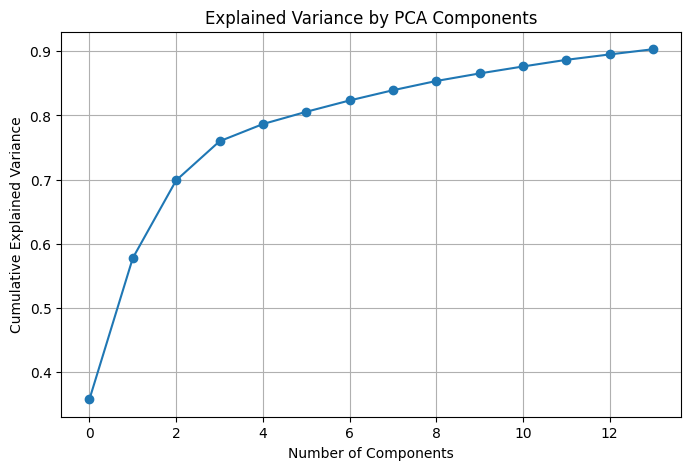

In [204]:
# Retain enough components to explain 90% of the variance
pca = PCA(n_components=0.9, random_state=42)
df_pca = pca.fit_transform(X_scaled)



print("Number of components selected:", pca.n_components_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

Explained variance ratio for all components: [3.57746766e-01 2.20029076e-01 1.21080834e-01 6.08470946e-02
 2.68356400e-02 1.91150144e-02 1.76646805e-02 1.59384965e-02
 1.44131750e-02 1.17701493e-02 1.08364320e-02 1.03651958e-02
 8.43025899e-03 8.09069815e-03 7.46562241e-03 6.36001098e-03
 5.62660896e-03 5.34475162e-03 5.17975425e-03 4.82708922e-03
 4.60699849e-03 4.43683101e-03 3.76893084e-03 3.58778317e-03
 3.25472107e-03 3.06397257e-03 2.91758366e-03 2.63646398e-03
 2.60113659e-03 2.49867622e-03 2.43038525e-03 2.12025890e-03
 2.02125452e-03 1.73316607e-03 1.54797169e-03 1.41681137e-03
 1.32040070e-03 1.26095934e-03 1.13241235e-03 1.06814358e-03
 9.89162305e-04 9.51921250e-04 8.38072414e-04 7.36853653e-04
 6.95029689e-04 6.57893643e-04 6.21297040e-04 5.88302795e-04
 5.43346487e-04 4.86704702e-04 4.74450306e-04 4.00970285e-04
 3.50773488e-04 3.41931133e-04 3.14081923e-04 2.88282582e-04
 2.69831406e-04 2.52264653e-04 2.16478191e-04 1.90930239e-04
 1.64924247e-04 1.47044389e-04 1.3658514

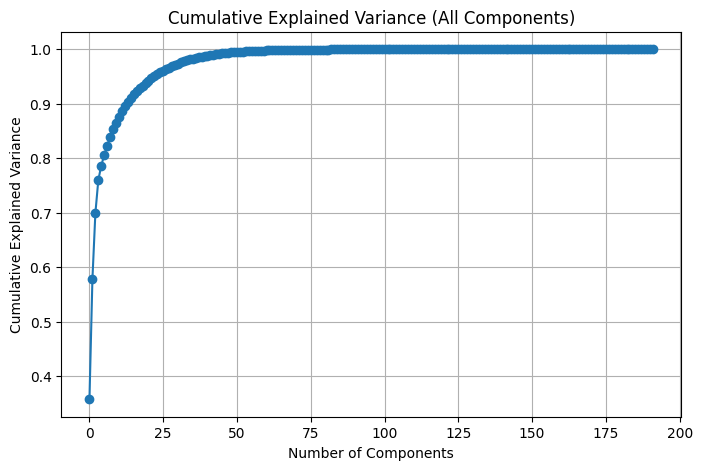

In [205]:
pca_full = PCA(n_components=None, random_state=42)
df_pca_full = pca_full.fit_transform(X_scaled)
print("Explained variance ratio for all components:", pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance (All Components)")
plt.grid(True)
plt.show()


In [206]:
# # Each row = feature, each column = principal component
# loadings = pd.DataFrame(
#     pca_full.components_.T,  # Transpose to have features as rows
#     index=features_df_log.columns,  # Feature names
#     columns=[f'PC{i+1}' for i in range(pca_full.n_components_)]
# )

# # Select top N components to visualize
# top_n = 5
# plt.figure(figsize=(12, min(0.5 * len(loadings), 12)))
# sns.heatmap(loadings.iloc[:, :top_n], annot=True, cmap='coolwarm', center=0)
# plt.title(f"PCA Loadings (Top {top_n} Components)")
# plt.xlabel("Principal Components")
# plt.ylabel("Original Features")
# plt.tight_layout()
# plt.show()

# # Create a dataframe that shows the relationship between the components and the original variables
# df_pca_comp = pd.DataFrame(data = pca.components_,
#                            columns = features_df_log.columns)

# # Create the Heat Map for Principal Components against original features. Again we use the RdBu color scheme and set borders to -1 and 1.
# plt.figure(figsize=(70,10))
# sns.heatmap(df_pca_comp,
#             vmin = -1, 
#             vmax = 1,
#             cmap = 'RdBu',
#             annot = True)

# plt.title('Components vs Original Features',fontsize = 14)
# plt.show()

In [207]:
np.cumsum(pca.explained_variance_ratio_)

array([0.35774677, 0.57777584, 0.69885668, 0.75970377, 0.78653941,
       0.80565443, 0.82331911, 0.8392576 , 0.85367078, 0.86544093,
       0.87627736, 0.88664255, 0.89507281, 0.90316351])

In [208]:
df_pca.shape

(5000, 14)

In [209]:
rows_n = df_pca.shape[0]

## Train Models

### Visualization Functions

### K means

In [210]:
def plot_clusters(df, clusters, principal_component_x=0, principal_component_y=1, principal_component_z=None):
    """
    Plots clusters using 2D or 3D PCA-transformed data.

    Parameters:
    - df: ndarray or DataFrame with PCA components
    - clusters: cluster labels
    - principal_component_x, principal_component_y: indexes of PCA components for 2D plot
    - principal_component_z: index of third component for 3D plot (optional)
    """
    
    if principal_component_z is not None and df.shape[1] > principal_component_z:
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(
            df[:, principal_component_x], 
            df[:, principal_component_y], 
            df[:, principal_component_z], 
            c=clusters, cmap="plasma", edgecolor='k'
        )
        ax.set_xlabel(f"Principal Component {principal_component_x + 1}")
        ax.set_ylabel(f"Principal Component {principal_component_y + 1}")
        ax.set_zlabel(f"Principal Component {principal_component_z + 1}")
        ax.set_title("Cluster Visualization (PCA 3D)")

        # Create legend
        unique_clusters = np.unique(clusters)
        handles = [
            mpatches.Patch(color=scatter.cmap(scatter.norm(cl)), label=f"Cluster {cl}")
            for cl in unique_clusters
        ]
        ax.legend(handles=handles, title="Cluster Label", loc="upper left")
        plt.show()

    elif df.shape[1] >= 2:
        # 2D Plot
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            df[:, principal_component_x], 
            df[:, principal_component_y], 
            c=clusters, cmap="plasma", edgecolor='k'
        )
        plt.xlabel(f"Principal Component {principal_component_x + 1}")
        plt.ylabel(f"Principal Component {principal_component_y + 1}")
        plt.title("Cluster Visualization (PCA 2D)")
        plt.grid(True)

        unique_clusters = np.unique(clusters)
        handles = [
            mpatches.Patch(color=scatter.cmap(scatter.norm(cl)), label=f"Cluster {cl}")
            for cl in unique_clusters
        ]
        plt.legend(handles=handles, title="Cluster Label", loc="best")
        plt.show()
    
    else:
        print("Not enough components to visualize clusters.")
        
    return None


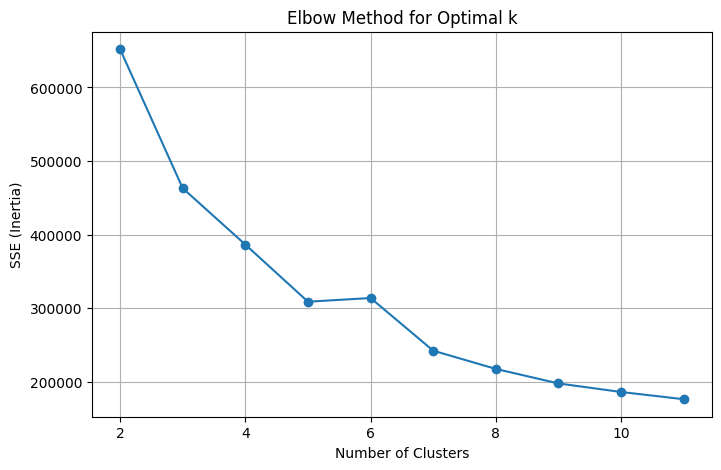

In [211]:
sse = []
k_range = range(2, 12)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_range), sse, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


In [219]:
k = 4 # Adjust this value based on the elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmeans = kmeans.fit_predict(df_pca)

# Evaluate clustering quality
sil_score = silhouette_score(df_pca, clusters_kmeans)
print("Silhouette Score:", sil_score)

dbi = davies_bouldin_score(df_pca, clusters_kmeans)
print(f"Davies-Bouldin Score: {dbi:.3f}")

Silhouette Score: 0.5487080799545893
Davies-Bouldin Score: 0.792


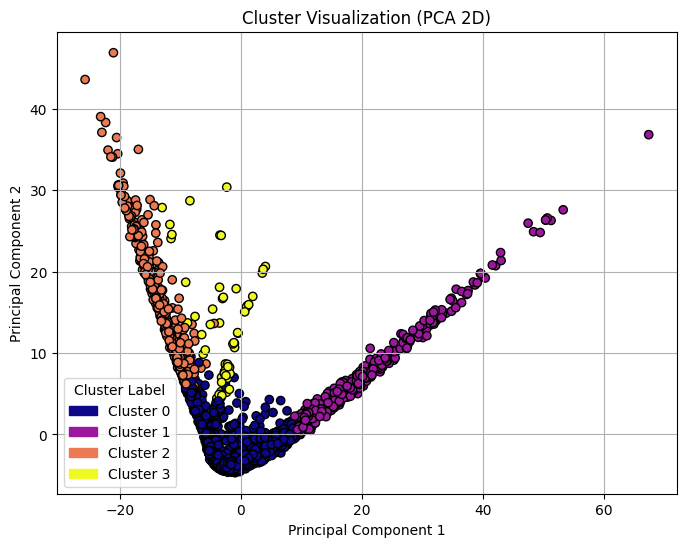

In [220]:
# Plot KMeans clusters from different PCA components

plot_clusters(df_pca, clusters_kmeans)
# plot_clusters(df_pca, clusters_kmeans, 0, 2)
# plot_clusters(df_pca, clusters_kmeans, 0, 3)
# plot_clusters(df_pca, clusters_kmeans, 0 ,4)
# plot_clusters(df_pca, clusters_kmeans, 1 ,2)
# plot_clusters(df_pca, clusters_kmeans, 0, 1, 2)

### DBSCAN

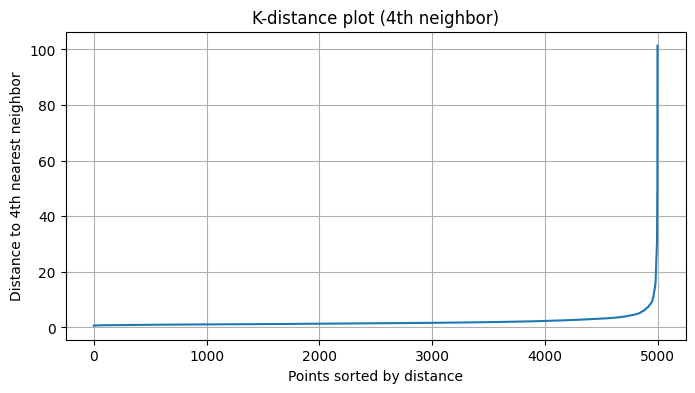

In [221]:
# Fit nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_pca)
distances, indices = neighbors_fit.kneighbors(df_pca)

# Sort distances to find the "knee" point
distances = np.sort(distances[:, 4])  # 4th nearest neighbor distance
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("K-distance plot (4th neighbor)")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to 4th nearest neighbor")
plt.grid(True)
plt.show()


In [222]:
# Try some values first
dbscan = DBSCAN(eps=5, min_samples=5)  # Adjust eps based on elbow plot
dbscan.fit(df_pca)

# Add cluster labels to original dataframe
labels = dbscan.labels_  # -1 means noise


In [223]:
# # Exclude noise points
# mask = labels != -1
# if len(set(labels)) > 1 and sum(mask) > 1:
#     score = silhouette_score(df_pca[mask], labels[mask])
#     print(f"Silhouette Score: {score:.3f}")
# else:
#     print("Not enough clusters (or too much noise) to compute silhouette score.")

    

# if len(set(labels)) > 1 and sum(mask) > 1:
#     dbi = davies_bouldin_score(df_pca[mask], labels[mask])
#     print(f"Davies-Bouldin Index: {dbi:.3f}")



In [224]:

# Define the eps range and min_samples
eps_values = np.arange(0.5, 15.0, 0.1)  # Adjust based on your k-distance plot
min_samples = 5

results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(df_pca)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    # Mask for non-noise points
    mask = labels != -1
    
    # Only evaluate if we have at least 2 clusters and some valid points
    if n_clusters >= 2 and np.sum(mask) > 10:
        silhouette = silhouette_score(df_pca[mask], labels[mask])
        dbi = davies_bouldin_score(df_pca[mask], labels[mask])
    else:
        silhouette = np.nan
        dbi = np.nan
    
    results.append({
        "eps": eps,
        "clusters": n_clusters,
        "noise_points": n_noise,
        "silhouette_score": silhouette,
        "davies_bouldin": dbi
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

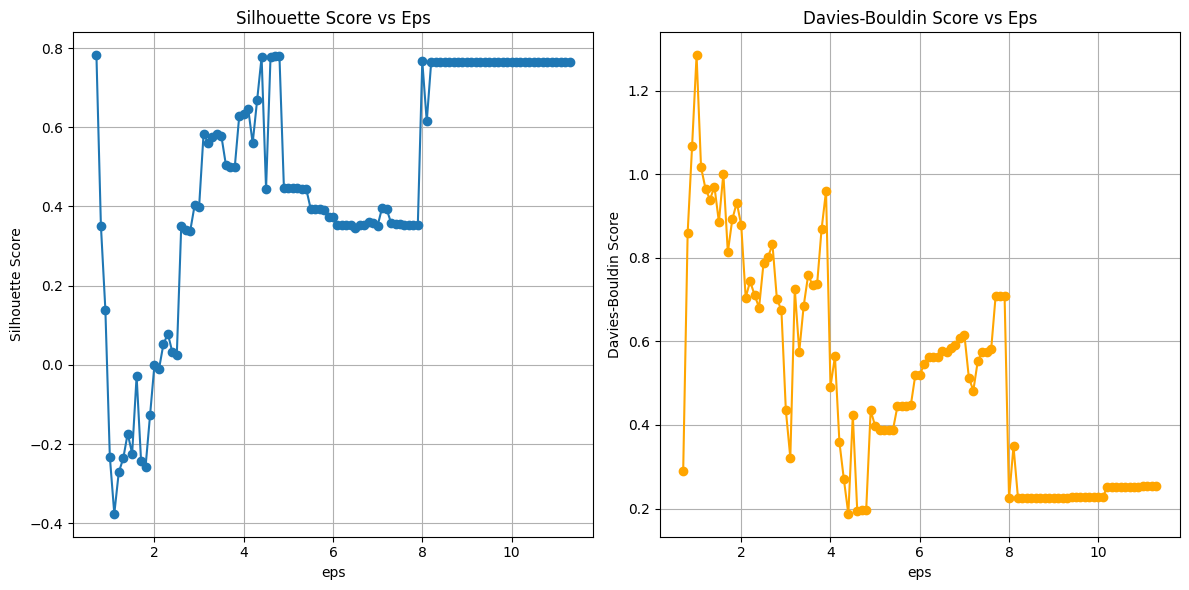

In [225]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results_df["eps"], results_df["silhouette_score"], marker='o')
plt.title("Silhouette Score vs Eps")
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results_df["eps"], results_df["davies_bouldin"], marker='o', color='orange')
plt.title("Davies-Bouldin Score vs Eps")
plt.xlabel("eps")
plt.ylabel("Davies-Bouldin Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [252]:
eps = 8

dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan.fit(df_pca)

# Add cluster labels to original dataframe
labels = dbscan.labels_  # -1 means noise


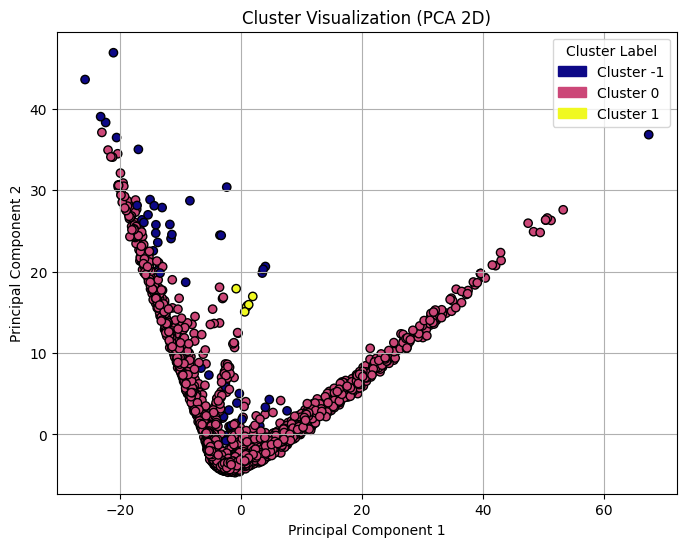

In [253]:
# Plot DBSCAN clusters from different PCA components
plot_clusters(df_pca, labels)

## Add Labels to Output Df

In [254]:
transformed_output_df.head()

,run_id,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,...,Pollution_min_25,Pollution_min_50,Pollution_min_75,Pollution_min_100,Pollution_min_125,Pollution_min_150,Pollution_min_175,Pollution_min_200,kmeans_cluster_id,dbscan_cluster_id
0,1.0,-0.000333,1.0,-0.000333,4.078005,1.000333,0.0,-1.000333,-0.099798,-0.044131,...,0.198781,0.196383,0.194562,0.192709,0.190859,0.189023,0.187204,0.187204,0,0
1,2.0,-0.000057,1.0,-0.000057,3.254820,1.000057,0.0,-1.000057,-0.111005,0.000000,...,0.308847,0.301477,0.292699,0.283613,0.274698,0.266042,0.257656,0.257656,0,0
2,3.0,-0.000046,1.0,-0.000046,4.719179,1.000046,0.0,-1.000046,-0.093226,-0.047939,...,1.487401,1.330770,1.190615,1.065205,0.952988,0.852576,0.762727,0.762727,0,0
3,4.0,-0.000146,1.0,-0.000146,5.885257,1.000146,0.0,-1.000146,-0.084761,-0.040375,...,0.613701,0.328344,0.175632,0.093906,0.050169,0.026763,0.014237,0.014237,0,0
4,5.0,-0.000198,1.0,-0.000198,4.738348,1.000198,0.0,-1.000198,-0.096086,-0.055946,...,0.282972,0.283623,0.290321,0.296705,0.302771,0.308842,0.315008,0.321291,0,0


In [255]:
# Add cluster labels to the transformed DataFrame
transformed_output_df["kmeans_cluster_id"] = clusters_kmeans
transformed_output_df["dbscan_cluster_id"] = labels
# Save the transformed DataFrame with cluster labels
transformed_output_df.to_csv(os.path.join(porcessed_data_dir, f'transformed_output_with_{k}_clusters.csv'), index=False)

# Create a new df to map run_id to cluster_id
cluster_mapping_df = transformed_output_df[["run_id", "kmeans_cluster_id", "dbscan_cluster_id"]]

cluster_mapping_df

,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.0,0,0
1,2.0,0,0
2,3.0,0,0
3,4.0,0,0
4,5.0,0,0
...,...,...,...
4995,4996.0,0,0
4996,4997.0,0,0
4997,4998.0,1,0
4998,4999.0,0,0


In [256]:
# Check for duplicates in the mapping DataFrame
print('duplicates: ', cluster_mapping_df.duplicated().sum())
# Check for null values in the mapping DataFrame
print('null values: \n', cluster_mapping_df.isnull().sum())

duplicates:  0
null values: 
 run_id               0
kmeans_cluster_id    0
dbscan_cluster_id    0
dtype: int64


In [257]:
output_df.head()

,Resources,Economy,Bureaucracy,Pollution,time,run_id
0,1.000000,1.000000,1.000000,1.000000,0.0,1.0
1,0.968867,1.015463,1.002266,0.989368,0.2,1.0
2,0.937852,1.030392,1.004657,0.978862,0.4,1.0
3,0.907016,1.044750,1.007171,0.968459,0.6,1.0
4,0.876418,1.058504,1.009802,0.958140,0.8,1.0


In [258]:
# Merge the cluster mapping DataFrame with the original output DataFrame
output_df_with_labels = output_df.merge(cluster_mapping_df, on="run_id", how="left")
output_df_with_labels.head()

,Resources,Economy,Bureaucracy,Pollution,time,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.000000,1.000000,1.000000,1.000000,0.0,1.0,0,0
1,0.968867,1.015463,1.002266,0.989368,0.2,1.0,0,0
2,0.937852,1.030392,1.004657,0.978862,0.4,1.0,0,0
3,0.907016,1.044750,1.007171,0.968459,0.6,1.0,0,0
4,0.876418,1.058504,1.009802,0.958140,0.8,1.0,0,0


In [259]:
output_df_with_labels.tail()

,Resources,Economy,Bureaucracy,Pollution,time,run_id,kmeans_cluster_id,dbscan_cluster_id
5004995,-0.000017,-0.000201,0.043258,0.045221,199.2,5000.0,0,0
5004996,-0.000017,-0.000201,0.043100,0.045058,199.4,5000.0,0,0
5004997,-0.000017,-0.000201,0.042942,0.044895,199.6,5000.0,0,0
5004998,-0.000017,-0.000201,0.042785,0.044733,199.8,5000.0,0,0
5004999,-0.000017,-0.000201,0.042629,0.044572,200.0,5000.0,0,0


In [260]:
# Sanity check that each run id is only in one cluster
output_df_with_labels.groupby("run_id")["kmeans_cluster_id"].nunique().value_counts()

kmeans_cluster_id
1    5000
Name: count, dtype: int64

In [261]:
# Save the output DataFrame with cluster labels
output_df_with_labels.to_csv(os.path.join(porcessed_data_dir, f'bardis_ensemble_python_ver_{rows_n}_k{k}_eps{eps}.csv'), index=False)